# Wie ist das Kaufverhalten?

In [332]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

Daten einlesen / aufbereiten

In [333]:
df_price = (
    pd.read_excel("./../../data/Preise.xlsx")
        .rename(columns={"Jahr": "year",
                         "preis": "price"})
        .assign(year=lambda _data: pd.to_numeric(_data["year"].str.strip('"')))
        .replace([20022, "Tablet Basics"],[2022, "Tablet Basic"])
)

df_dt = (
    pd.read_excel("./../../data/Downtime.xlsx")
        .rename(columns={"Unnamed: 0": "year",
                         "Region A": "a",
                         "Region B": "b",
                         "Region C": "c",
                         "Region D": "d"})
)

df_crm = (
    pd.read_excel("./../../data/CRM_data.xlsx")
        .rename(columns={"id": "transaction_id",
                         "vorname": "firstname",
                         "nachname": "lastname"})
)

def read_regio_data(region, kind): 
    return (pd.read_excel(f"./../../data/Region{region}_{kind}.xlsx")
                .rename(columns={"Tablet Basic": "basic",
                                "Tablet Mini": "mini",
                                "Tablet Pro": "pro",
                                "kosten_mini": "cost_mini",
                                "kosten_basic": "cost_basic",
                                "kosten_pro": "cost_pro",
                                "PRODUKT": "product"})
                .assign(year=lambda _data: _data["date"].dt.year,
                        month=lambda _data: _data["date"].dt.month,
                        week=lambda _data: _data["date"].dt.isocalendar().week,
                        year_month=lambda _data: _data["date"].dt.year.astype(str) + "_" + _data["date"].dt.month.astype(str),
                        cost_basic=lambda _data: np.round(_data["cost_basic"], 2),
                        cost_mini=lambda _data: np.round(_data["cost_mini"], 2),
                        cost_pro=lambda _data: np.round(_data["cost_pro"], 2),
                        cost_per_unit=lambda _data: _data["cost_basic"].fillna(0) + _data["cost_mini"].fillna(0) + _data["cost_pro"].fillna(0),
                        cost=lambda _data: _data["cost_per_unit"] * _data["amount"]
                        )
                .merge(df_price, on=["year", "product"])
                .assign(revenue=lambda _data: _data["price"] * _data["amount"],
                        profit_per_unit=lambda _data: _data["price"] - _data["cost_per_unit"],
                        profit=lambda _data: _data["profit_per_unit"] * _data["amount"])
                .merge(df_crm[["customer_rating", "email", "transaction_id"]], on="transaction_id"))


df_regAo = read_regio_data("A","online")
df_regAp = read_regio_data("A","phone")
df_regAs = read_regio_data("A","store")
df_regBo = read_regio_data("B","online")
df_regBp = read_regio_data("B","phone")
df_regBs = read_regio_data("B","store")
df_regCo = read_regio_data("C","online")
df_regCp = read_regio_data("C","phone")
df_regCs = read_regio_data("C","store")
df_regDo = read_regio_data("D","online")
df_regDp = read_regio_data("D","phone")
df_regDs = read_regio_data("D","store")

# Array mit Zuordnung der DataFrames zu Region und Marketplace
dataframes = [
    (df_regAo, 'A', 'online'),
    (df_regAp, 'A', 'phone'),
    (df_regAs, 'A', 'store'),
    (df_regBo, 'B', 'online'),
    (df_regBp, 'B', 'phone'),
    (df_regBs, 'B', 'store'),
    (df_regCo, 'C', 'online'),
    (df_regCp, 'C', 'phone'),
    (df_regCs, 'C', 'store'),
    (df_regDo, 'D', 'online'),
    (df_regDp, 'D', 'phone'),
    (df_regDs, 'D', 'store')
]

# Spezifisiche Region und Marktplatz zu jedem Frame hinzufügen
for df_reg_main, region, marketplace in dataframes:
    df_reg_main['region'] = region
    df_reg_main['marketplace'] = marketplace

# Alle DataFrames zusammenfügen (concat)
# ignore_index=True: Index wird neu erstellt
df_reg_main = pd.concat([df for df, _, _ in dataframes], ignore_index=True)


In [334]:
df_reg_main = df_reg_main.assign(count=[1 for i in range(len(df_reg_main))])

In [335]:
df_reg_main.describe()

,date,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,transaction_id,...,month,week,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,count
count,335253,300164.000000,335253.000000,335253.000000,335253.000000,335253.000000,75253.000000,110000.00000,150000.000000,335253.000000,...,335253.000000,335253.0,335253.000000,335253.000000,335253.00000,335253.000000,335253.000000,335253.000000,335253.000000,335253.0
mean,2022-05-13 00:24:06.816583424,0.988871,2.405234,0.224466,0.328110,0.447423,286.214998,211.65353,855.001512,170761.352584,...,6.574745,26.73928,516.238937,1162.729318,748.38011,1739.700176,232.141173,576.970857,7.587594,1.0
min,2021-11-01 00:00:00,0.900000,1.000000,0.000000,0.000000,0.000000,150.000000,136.02000,486.090000,0.000000,...,1.000000,1.0,136.020000,136.020000,499.00000,499.000000,-186.370000,-2050.070000,1.600000,1.0
25%,2022-02-13 00:00:00,1.000000,1.000000,0.000000,0.000000,0.000000,215.000000,171.57000,805.340000,85937.000000,...,4.000000,14.0,206.730000,447.340000,550.00000,999.000000,133.130000,215.940000,6.700000,1.0
50%,2022-05-18 00:00:00,1.000000,2.000000,0.000000,0.000000,0.000000,276.590000,196.21000,859.115000,171144.000000,...,7.000000,27.0,349.530000,862.610000,680.00000,1497.000000,230.190000,392.620000,7.700000,1.0
75%,2022-08-13 00:00:00,1.000000,3.000000,0.000000,1.000000,1.000000,344.040000,259.94000,909.410000,255788.000000,...,9.000000,39.0,847.510000,1705.780000,999.00000,2116.000000,350.620000,768.750000,8.700000,1.0
max,2022-10-31 00:00:00,1.000000,17.000000,1.000000,1.000000,1.000000,685.370000,326.26000,985.000000,339999.000000,...,12.000000,52.0,985.000000,9557.520000,999.00000,12987.000000,512.910000,7110.600000,10.000000,1.0
std,NaN,0.031449,1.579624,0.417231,0.469526,0.497229,86.871362,51.42493,73.858664,98109.396928,...,3.329539,14.505512,314.110280,939.646248,228.49302,1125.267154,120.618094,548.731709,1.580079,0.0


In [336]:
df_reg_main.head()

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,cost,price,revenue,profit_per_unit,profit,customer_rating,email,region,marketplace,count
0,2021-11-01,Tablet Basic,1.0,5,1,0,0,170.02,NaN,NaN,...,850.10,529,2645,358.98,1794.90,7.1,friedhilde.kuhl@yahoo.de,A,online,1
1,2021-11-01,Tablet Basic,1.0,7,1,0,0,170.02,NaN,NaN,...,1190.14,529,3703,358.98,2512.86,5.9,heide-marie.fischer@gmx.de,A,online,1
2,2021-11-01,Tablet Basic,0.9,7,1,0,0,210.03,NaN,NaN,...,1470.21,529,3703,318.97,2232.79,7.5,ester.pruschke@gmail.com,A,online,1
3,2021-11-01,Tablet Basic,1.0,10,1,0,0,170.08,NaN,NaN,...,1700.80,529,5290,358.92,3589.20,6.6,klaus.blümel@aol.de,A,online,1
4,2021-11-01,Tablet Basic,1.0,4,1,0,0,170.09,NaN,NaN,...,680.36,529,2116,358.91,1435.64,7.3,waldemar.fritsch@web.de,A,online,1


In [337]:
df_reg_main.columns

Index(['date', 'product', 'discount', 'amount', 'basic', 'mini', 'pro',
       'cost_basic', 'cost_mini', 'cost_pro', 'transaction_id', 'year',
       'month', 'week', 'year_month', 'cost_per_unit', 'cost', 'price',
       'revenue', 'profit_per_unit', 'profit', 'customer_rating', 'email',
       'region', 'marketplace', 'count'],
      dtype='object')

# **Transaktionen**

## Wie entwickelt sich die Transaktionsanzahl pro Zeiteinheit (monatlich)?
-> Die Anzahl monatlicher Transaktionen steigt kontinuierlich über das Jahr hinweg
-> Dadurch steigen implizit auch Verwaltungskosten für die Bestellungen insgesamt (Zusammenstellung, Verpackung, Versand, Rechnungsverwaltung, Kundenkommunikation)

C:\Users\morit\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


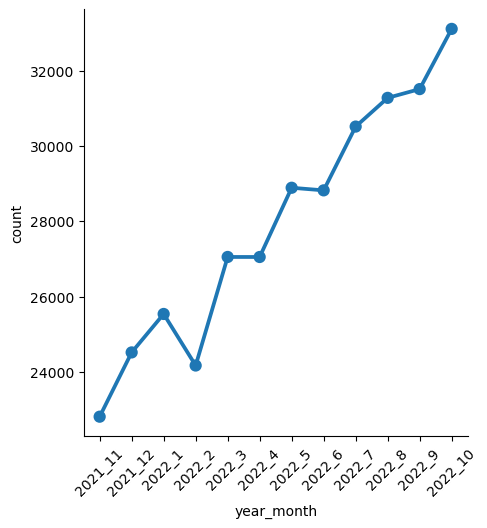

In [338]:
cat = sns.catplot(data=df_reg_main, x="year_month", y="count", estimator="sum", kind="point", errorbar=None)
cat.set_xticklabels(rotation=45)

## Wie entwickelt sich die Menge an Produkten pro Transaktion? 
-> sinkt kontinuierlich ab, allerdings nur von durchschnittlich 2.6 auf 2.2 Produkte pro Bestellung

C:\Users\morit\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


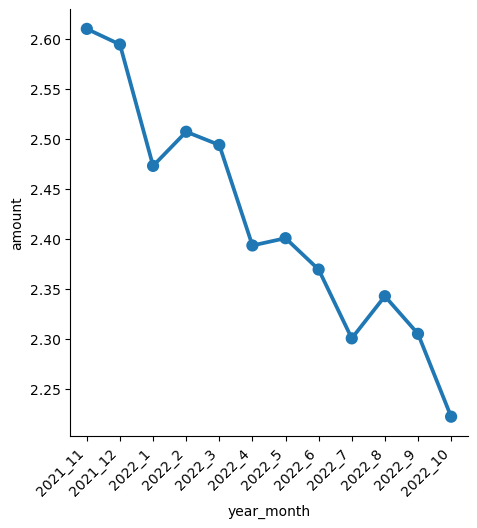

In [339]:
chart = sns.catplot(data=df_reg_main, x="year_month", y="amount", kind="point", errorbar=None)
chart.set_xticklabels(rotation=45, horizontalalignment='right')

# **Menge**

## Wie entwickelt sich die verkaufte Menge pro Produkt?
-> Tablet Mini Verkauf ist gleichbleibend
-> Tablet Basic Verkauf sinkt ab
-> Tablet Pro Verkauf steigt

Resultierende Frage / These: Wird mit dem Pro Modell weniger Marge gemacht, als mit dem Basic Modell? 
Sodass weniger Marge dann auch noch höhere Verwaltungskosten durch gestiegene Anzahl an Transaktionen gegenüber stehen

C:\Users\morit\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


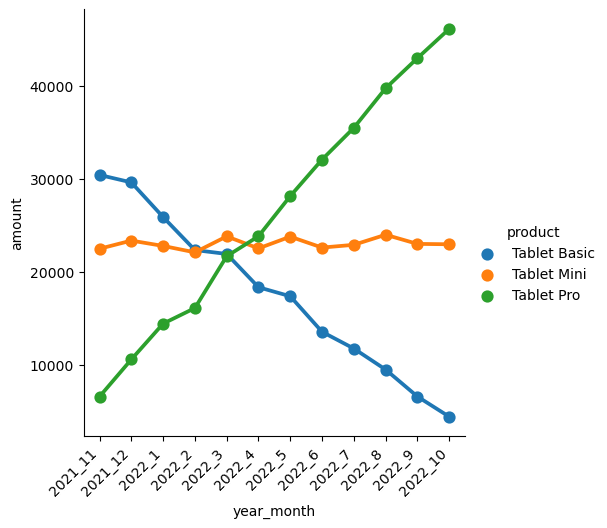

In [340]:
chart = sns.catplot(data=df_reg_main, x="year_month", y="amount", estimator="sum", kind="point", hue="product", errorbar=None)
chart.set_xticklabels(rotation=45, horizontalalignment='right')

# **Discounts**

## Wie entwickeln sich die Discounts im Vergleich auf den verschiedenen Marktplätzen?
-> Discounts steigen auf allen Marktplätzen => Das verringert auch den Gewinn über die Zeit

C:\Users\morit\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


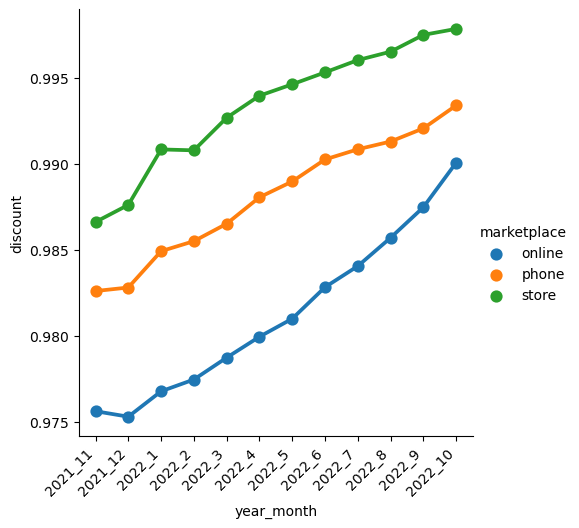

In [341]:
chart = sns.catplot(data=df_reg_main, x="year_month", y="discount", kind="point", hue="marketplace", errorbar=None)
chart.set_xticklabels(rotation=45, horizontalalignment='right')

[Text(0, 0, '0.98043'), Text(0, 0, '0.988477'), Text(0, 0, '0.994245')]

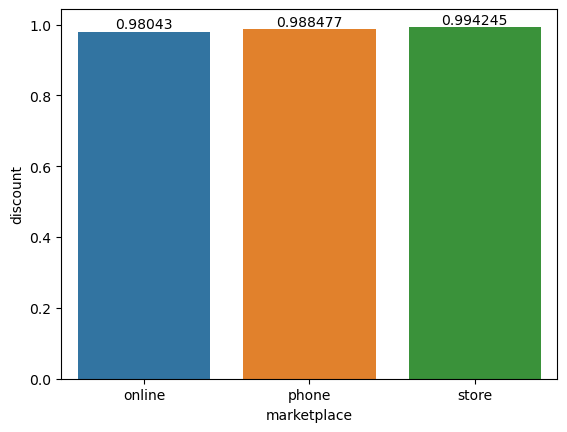

In [342]:
chart = sns.barplot(data=df_reg_main, x="marketplace", y="discount", errorbar=None)
chart.bar_label(chart.containers[0], fontsize=10)

## Wie entwickelt sich die Anzahl an verkauften Tablets bei einem Discount im Vergleich zu keinem Discount?
-> Die Anzahl der verkauften Tablets die nicht rabatiert sind steigt, die der rabatierten sinkt
-> Die Durschnittsanzahl pro Bestellung mit Discount steigt, die ohne sinkt
-> Der Anteil an verkauften Tablets mit einem Discount sinkt

C:\Users\morit\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


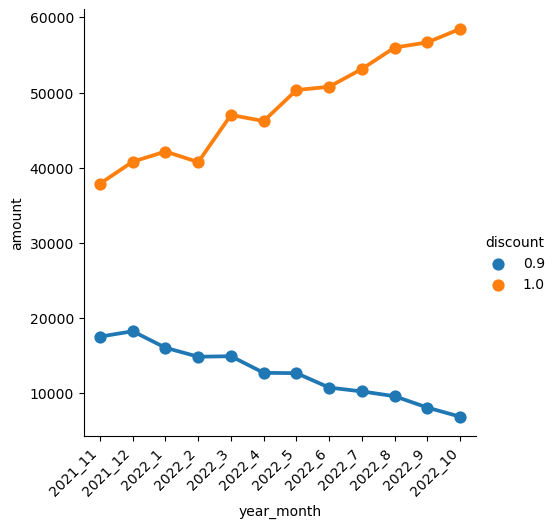

In [343]:
# Entwicklung der Summe der Menge an verkauften Produkten
chart = sns.catplot(data=df_reg_main, x="year_month", y="amount", kind="point", hue="discount", estimator="sum", errorbar=None)
chart.set_xticklabels(rotation=45, horizontalalignment='right')

C:\Users\morit\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


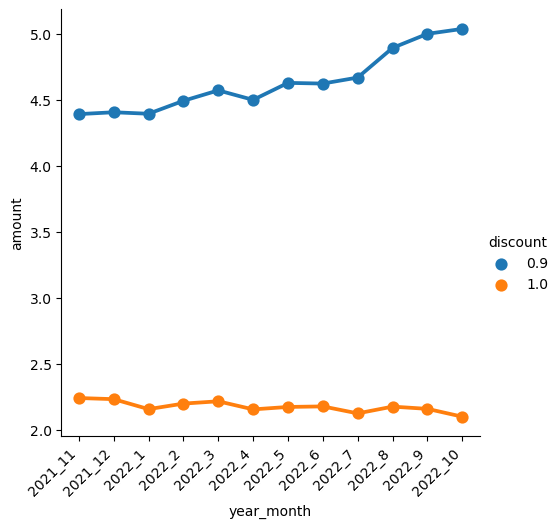

In [344]:
# Entwicklung der Durschschnittsmenge pro Transkation
chart = sns.catplot(data=df_reg_main, x="year_month", y="amount", kind="point", hue="discount", errorbar=None)
chart.set_xticklabels(rotation=45, horizontalalignment='right')

C:\Users\morit\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


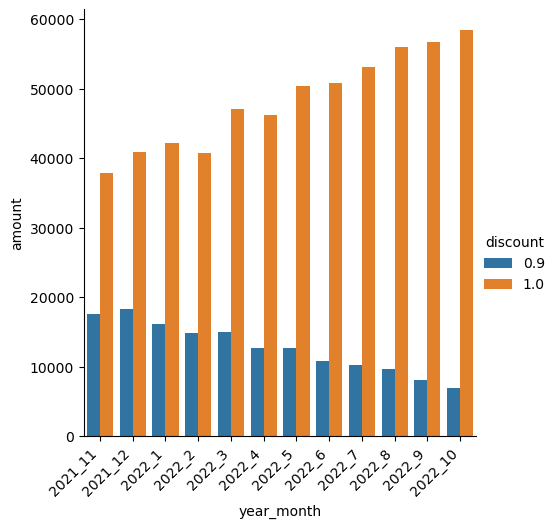

In [345]:
# Entwicklung der Summe der Menge an verkauften Produkten pro discount
chart = sns.catplot(data=df_reg_main, x="year_month", y="amount", hue="discount", kind="bar", estimator="sum", errorbar=None)
chart.set_xticklabels(rotation=45, horizontalalignment='right')

# **Gewinn**

## Wie entwickeln sich Umsatz und Kosten pro Produkt?
-> Gewinn / Profit pro Einheit sinkt für Tablet Basic und Pro (doch wie oben zu sehen steigt der Verkauf für Tablet Pro => Gewinn insgesamt sinkt)

C:\Users\morit\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


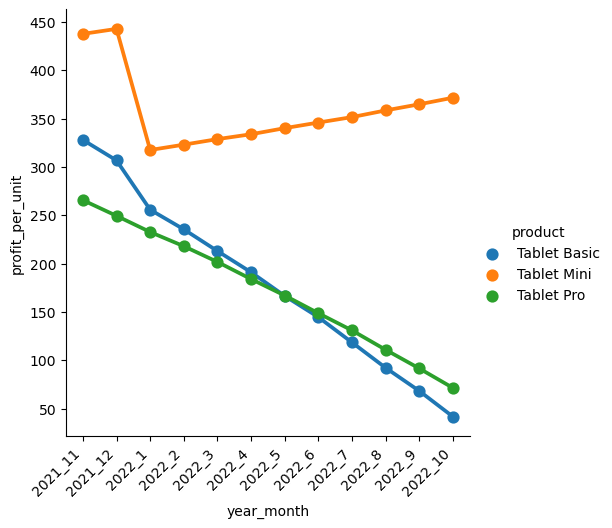

In [346]:
chart = sns.catplot(data=df_reg_main, x="year_month", y="profit_per_unit", kind="point", errorbar=None, hue="product")
chart.set_xticklabels(rotation=45, horizontalalignment='right')

# Veraltet

C:\Users\morit\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


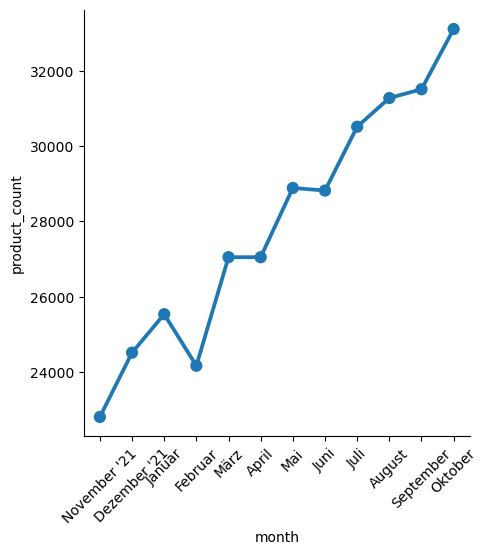

In [347]:
# Veraltet

def aggregate_per_month(df, column_to_agg, agg_function, return_daily=False):
    '''
    Funktion, um eine Spalte des df_reg_main korrekt nach dem Monat(-sende) zu aggregieren.
    df = df_reg_main
    column_to_agg = Spalte die aggregiert werden soll
    agg_function = Funktion nach der aggregiert werden soll (wenn z.B. die Anzahl der Reihen gezählt werden soll -> "count", es geht auch "sum" oder "mean")
    '''
    
    # transaktionsdaten nach tag aggregieren (ausgehend von date spalte)
    df_count_daily = df.groupby("date").agg({column_to_agg: agg_function}) 

    # entsprechend der aggregations art die summe nehmen bei der monatlichen aggregation oder den mittelwert
    if agg_function == "count" or agg_function == "sum":
        df_monthly = df_count_daily.resample('M').sum()
    elif agg_function == "mean":
        df_monthly = df_count_daily.resample('M').mean()
    else:
        raise Error('Diese Aggregationsfunktion ist (noch) nicht in der Funktion "aggregate_per_month" vorgesehen.')

    # umbenennen der spalte sodass man weiß was da dann drin steht
    column_name = f"{column_to_agg}_{agg_function}"
    df_monthly.rename(columns={column_to_agg: column_name}, inplace=True)

    # Monat aus dem "date" extrahieren und neue Spalte erstellen
    df_monthly['month'] = df_monthly.index.month
    # Monate durch die Namen der Monate ersetzen (für die Darstellung)
    monate = ["Januar", "Februar", "März", "April", "Mai", "Juni", "Juli", "August", "September", "Oktober", "November '21", "Dezember '21"]
    df_monthly.replace([int(i) for i in np.linspace(1,12,12)], monate, inplace=True)
    # ändern der reihenfolge der spalten damit monat vorn steht
    df_monthly = df_monthly[["month", column_name]]

    if return_daily:
        return df_monthly, df_count_daily

    return df_monthly

# Monatliche Aggregation
monthly_transactions = aggregate_per_month(df_reg_main, "product", "count")

cat = sns.catplot(data=monthly_transactions, x="month", y="product_count", kind="point", errorbar=None)
cat.set_xticklabels(rotation=45)